# Rede Neural Gato vs Cachorro InceptionV3

In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

## Trabalhando o conjunto de dados

In [4]:
# fazendo download do dataset
if not os.path.exists('dataset/cats_and_dogs_filtered.zip'):
    !wget -P dataset https://www.dropbox.com/sh/m9mictdafh3c215/AAAukjvq8byO6jbKCoIev3_Ja?dl=1

# renomeando o arquivo
!mv dataset/AAAukjvq8byO6jbKCoIev3_Ja?dl=1 dataset/cats_and_dogs_filtered.zip

--2022-10-17 18:31:40--  https://www.dropbox.com/sh/m9mictdafh3c215/AAAukjvq8byO6jbKCoIev3_Ja?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.71.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.71.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/dl/m9mictdafh3c215/AAAukjvq8byO6jbKCoIev3_Ja [following]
--2022-10-17 18:31:40--  https://www.dropbox.com/sh/dl/m9mictdafh3c215/AAAukjvq8byO6jbKCoIev3_Ja
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc18d35c350afd336443bfaa5b4a.dl.dropboxusercontent.com/zip_download_get/BSaNaP6y5In9A-mTZ0ebtdWYl4TlfXCVcH8q7SMAWG9Oyd1gpOQ7dGy5KZgTqcczU7yhYcRvixpdVAk4ZVJI3KK5E2lReyu3TgGYlua3PpWkPg?dl=1# [following]
--2022-10-17 18:31:45--  https://uc18d35c350afd336443bfaa5b4a.dl.dropboxusercontent.com/zip_download_get/BSaNaP6y5In9A-mTZ0ebtdWYl4TlfXCVcH8q7SMAWG9Oyd1gpOQ7dGy5KZgTqcczU7yhYcRvixpdVAk4ZVJI3K

In [6]:
# organizando as pastas das imagens
local_zip = 'dataset/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/cats_and_dogs_filtered')
zip_ref.close()

# separando as pastas para treino e validação 
base_dataset_dir = 'tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dataset_dir, 'train')
validation_dir = os.path.join(base_dataset_dir, 'validation')
 
# pasta de treino com a imagens de gato
train_cats = os.path.join(train_dir, 'cats')
 
# pasta de treino com a imagens de cachorro
train_dogs = os.path.join(train_dir, 'dogs')
 
# pasta de validação com imagens de gato
validation_cats = os.path.join(validation_dir, 'cats')
 
# pasta de validação com imagens de gato
validation_dogs = os.path.join(validation_dir, 'dogs')

## Exibição de uma amostra do conjunto de dados

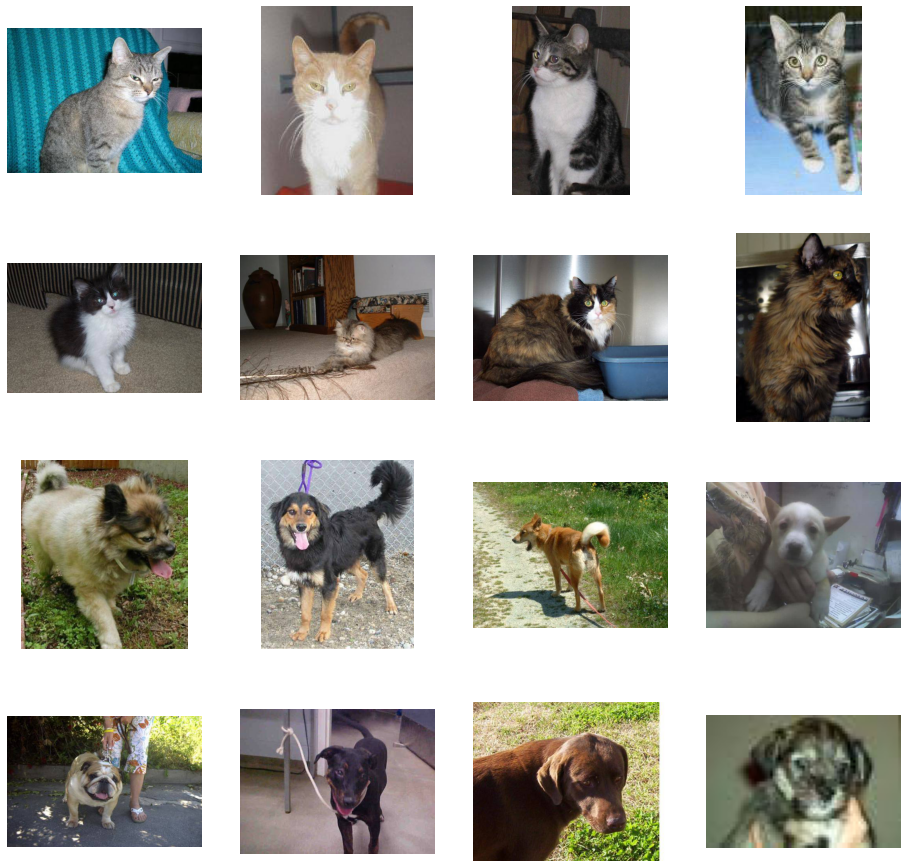

In [7]:
# configurando o matplotlib para exibir uma amostra de imagens, 
# em um arranjo de 4 linha X 4 colunas 
import matplotlib.image as mpimg
nrows = 4
ncols = 4
 
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_files = os.listdir( train_cats )
train_dog_files = os.listdir( train_dogs )
 
 
next_cat_img = [os.path.join(train_cats, fname)
                for fname in train_cat_files[ pic_index-8:pic_index]
               ]
 
next_dog_img = [os.path.join(train_dogs, fname)
                for fname in train_dog_files[ pic_index-8:pic_index]
               ]
 
for i, img_path in enumerate(next_cat_img+next_dog_img):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # não exibir gridlines
 
  img = mpimg.imread(img_path)
  plt.imshow(img)
 
plt.show()

## Preparação das imagens e separação das pastas de treinamento e validação

In [8]:
# preparando a configuração de aumento de dados
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 50,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
 
test_datagen = ImageDataGenerator(rescale = 1.0/255.)
 
# configurando o flow_form_directory (pasta das imagens, quantidada de arquivos 
# por lote, classes, tamanho padronizado das imagens)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))    
 
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size  = 20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Preparação do modelo InceptionV3

In [9]:
# instanciando o modelo Inception V3 com pré-treino no 'imagenet'
base_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = 'imagenet')

# primeiro: treina apenas as camadas superiores (que foram inicializadas aleatoriamente)
# congela todas as camadas convolucionais do InceptionV3
for layer in base_model.layers:
  layer.trainable = False
 
# o treinamento será parado assim que a acurácia ultrapassar 99%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.99):
      self.model.stop_training = True

87910968/87910968 [==============================] - 0s 0us/step


## Treinamento do modelo

In [10]:
# instanciando as camadas do modelo
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                 
x = layers.Dense  (1, activation='sigmoid')(x)          
 
model = Model( base_model.input, x)
 
# otimizador RMSprop com learning rate (lr) 0.00001 e função de custo entropia cruzada binária
model.compile(optimizer = RMSprop(lr=0.0001),loss = 'binary_crossentropy',metrics = ['acc']) 
callbacks = myCallback()
 
# gardando as informações do treinamento
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
100/100 - 32s - loss: 1.3432 - acc: 0.8460 - val_loss: 0.3144 - val_acc: 0.9260 - 32s/epoch - 319ms/step
Epoch 2/100
100/100 - 19s - loss: 0.4591 - acc: 0.8880 - val_loss: 0.2144 - val_acc: 0.9420 - 19s/epoch - 190ms/step
Epoch 3/100
100/100 - 19s - loss: 0.4147 - acc: 0.8990 - val_loss: 0.3001 - val_acc: 0.9340 - 19s/epoch - 190ms/step
Epoch 4/100
100/100 - 20s - loss: 0.3660 - acc: 0.8960 - val_loss: 0.2051 - val_acc: 0.9420 - 20s/epoch - 197ms/step
Epoch 5/100
100/100 - 19s - loss: 0.3453 - acc: 0.9005 - val_loss: 0.1183 - val_acc: 0.9620 - 19s/epoch - 189ms/step
Epoch 6/100
100/100 - 19s - loss: 0.3397 - acc: 0.9095 - val_loss: 0.1368 - val_acc: 0.9560 - 19s/epoch - 191ms/step
Epoch 7/100
100/100 - 19s - loss: 0.3253 - acc: 0.9090 - val_loss: 0.1309 - val_acc: 0.9670 - 19s/epoch - 189ms/step
Epoch 8/100
100/100 - 19s - loss: 0.3503 - acc: 0.9040 - val_loss: 0.5698 - val_acc: 0.8850 - 19s/epoch - 190ms/step
Epoch 9/100
100/100 - 22s - loss: 0.3059 - acc: 0.9160 - val_los

## Exibição dos resultados em gráfico

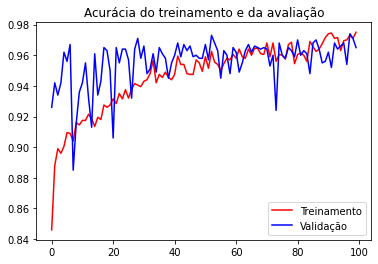

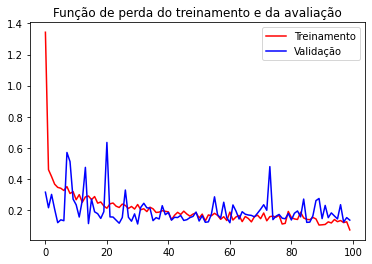

In [13]:
# instanciando o resultado das métricas
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
# exibindo em gráfico as informações do treinamento e a avaliação
plt.plot(epochs, acc, 'r', label='Treinamento')
plt.plot(epochs, val_acc, 'b', label='Validação')
plt.title('Acurácia do treinamento e da avaliação')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'r', label='Treinamento')
plt.plot(epochs, val_loss, 'b', label='Validação')
plt.title('Função de perda do treinamento e da avaliação')
plt.legend();